In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2023-12-28 12:38:22.505733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 12:38:22.720165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 12:38:23.478706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-28 12:38:23.478813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## retrieve data for validation and process into correct format

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)

# read in validation data
hit_val = pd.read_csv('../outputs/model_v5/validation.pos.csv', index_col=0)
irr_val = pd.read_csv('../outputs/model_v5/validation.neg.csv', index_col=0)

# create X for validation
X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
# combine
X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
X_val = X_val_cdr3s.join(X_val_epitopes)

# grab y for validation
y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                     pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
y_val = y_val.reset_index().iloc[:, 1:][0]

# confirm the same length
assert X_val.shape[0] == y_val.shape[0]

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_val = X_val[means.index]
# normalize
X_val -= means
X_val /= stds

## compare with other models

In [9]:
!mkdir ../outputs/model_comparison

mkdir: cannot create directory ‘../outputs/model_comparison’: File exists


In [10]:
# select for epitopes that are test-able
for epitope in ['GILGFVFTL','NLVPMVATV','GLCTLVAML']:
    # append the original dataframes together for further testing
    df_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
    # subset on the relevant peptide
    y = y_val.loc[df_val['Epitope'] == epitope]
    df_val = df_val.loc[df_val['Epitope'] == epitope]
    # write the files down
    df_val.to_csv(f'../outputs/model_comparison/val.{epitope}.csv')
    y.to_csv(f'../outputs/model_comparison/val.{epitope}.y.csv')

In [19]:
# loop through the filenames to create appropriate inputs
for epitope in ['GILGFVFTL','NLVPMVATV','GLCTLVAML']:
    # read in input dataframes
    X = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.csv', index_col=0)
    y = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.y.csv', index_col=0)
    
    # write for ATM-TCR
    fn = f'../outputs/model_comparison/val.{epitope}.ATM-TCR.csv'
    pd.concat([X, y], axis=1).to_csv(fn, header=False, index=False)

    # write for pMTnet
    tmp = X.copy()
    tmp['HLA'] = 'A*02:01'
    tmp.columns = ['CDR3','Antigen','HLA']
    fn = f'../outputs/model_comparison/val.{epitope}.pMTnet.csv'
    tmp.to_csv(fn, index=False)

    # write for NetTCR2 (CLI version)
    fn = f'../outputs/model_comparison/val.{epitope}.NetTCR2_CLI.csv'
    tmp = X.copy()
    tmp.columns = ['CDR3b','peptide']
    tmp['CDR3a'] = None
    tmp[['CDR3a','CDR3b','peptide']].to_csv(fn, index=False)

    # write for ImRex
    fn = f'../outputs/model_comparison/val.{epitope}.ImRex.csv'
    tmp = X.copy()
    tmp.columns = ['cdr3','antigen.epitope']
    tmp.to_csv(fn, index=False, sep=';')

    # write for ERGO-II
    fn = f'../outputs/model_comparison/val.{epitope}.ERGOII.csv'
    tmp = X.copy()
    tmp.columns = ['TRB','Peptide']
    tmp['MHC'] = 'HLA-A*02'
    tmp['T-Cell-Type'] = 'CD8'
    tmp = tmp.T.reindex(['TRA','TRB','TRAV','TRAJ','TRBV','TRBJ','T-Cell-Type','Peptide','MHC']).T
    tmp.to_csv(fn, index=False)

In [ ]:
# > code for running pMTnet (in base_py38)
# nohup python pMTnet.py \
# -input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.pMTnet.csv \
# -library /ssd1/dchen/GNN_PEPTIDE_TCR/external/pMTnet/library \
# -output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.pMTnet.results \
# -output_log /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.pMTnet.results.log &
# nohup python pMTnet.py \
# -input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.pMTnet.csv \
# -library /ssd1/dchen/GNN_PEPTIDE_TCR/external/pMTnet/library \
# -output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.pMTnet.results \
# -output_log /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.pMTnet.results.log &
# nohup python pMTnet.py \
# -input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.pMTnet.csv \
# -library /ssd1/dchen/GNN_PEPTIDE_TCR/external/pMTnet/library \
# -output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.pMTnet.results \
# -output_log /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.pMTnet.results.log &

# > code for running ATM-TCR (in base_py37)
# python main.py --infile /ssd1/dchen/GNN_PEPTIDE_TCR/external/ATM-TCR/data/combined_dataset.csv \
# --indepfile /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ATM-TCR.csv \
# --model_name original.ckpt --mode test --save_model False --cuda False
# python main.py --infile /ssd1/dchen/GNN_PEPTIDE_TCR/external/ATM-TCR/data/combined_dataset.csv \
# --indepfile /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ATM-TCR.csv \
# --model_name original.ckpt --mode test --save_model False --cuda False
# python main.py --infile /ssd1/dchen/GNN_PEPTIDE_TCR/external/ATM-TCR/data/combined_dataset.csv \
# --indepfile /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ATM-TCR.csv \
# --model_name original.ckpt --mode test --save_model False --cuda False

# > code for ImRex (in deepTCR)
# python ./src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 \
# --input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ImRex.csv \
# --output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ImRex.result.csv
# python ./src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 \
# --input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ImRex.csv \
# --output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ImRex.result.csv
# python ./src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 \
# --input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ImRex.csv \
# --output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ImRex.result.csv

# > code for ERGOII (in ergoii)
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.ERGOII.results_vdjdb.csv
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.ERGOII.results_vdjdb.csv
# python Predictv2.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ERGOII.results.csv
# python Predictv2.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ERGOII.csv \
# /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.ERGOII.results_vdjdb.csv

# > code for NetTCR (in base_py37)
# python nettcr.py -tr test/sample_train.csv -c b \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GILGFVFTL.NetTCR2.results.csv
# python nettcr.py -tr test/sample_train.csv -c b \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.NLVPMVATV.NetTCR2.results.csv
# python nettcr.py -tr test/sample_train.csv -c b \
# -te /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.NetTCR2_CLI.csv \
# -o /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.GLCTLVAML.NetTCR2.results.csv


In [4]:
# get it in nice plotting stage
from sklearn.metrics import roc_curve, auc, accuracy_score
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [5]:
def evaluation(epitope):
    # append the original dataframes together for further testing
    df_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
    # focus on validation dataframe for independence
    X = X_val.loc[df_val['Epitope'] == epitope]
    y = y_val.loc[df_val['Epitope'] == epitope]

    # retrieve the appropriate columns
    cols_cdr3 = X.columns[X.columns.str.startswith('cdr3')]
    cols_ag = X.columns[X.columns.str.startswith('ag')]
    
    # create tracking variable
    models = ['TARPON','pMTnet','ATM-TCR','ImRex','NetTCR2','ERGOII-McPAS','ERGOII-VDJdb','AVIB']
    df_metrics = pd.DataFrame(index=['AUC','ACC'], columns=models)

    # load in the model
    model = keras.models.load_model('../outputs/model_v5/model_v5.r1.keras')

    # > our model
    # testing predictions
    y_pred = model.predict([X[cols_cdr3], X[cols_ag]], workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_modelv5, tpr_modelv5, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Model v5')
    print('AUC', auc(fpr_modelv5, tpr_modelv5))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['TARPON'] = auc(fpr_modelv5, tpr_modelv5), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))
    
    # > pMTnet
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.pMTnet.results/prediction.csv')
    y_pred = 1 - y_pred['Rank'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_pmtnet, tpr_pmtnet, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('pMTnet')
    print('AUC', auc(fpr_pmtnet, tpr_pmtnet))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['pMTnet'] = auc(fpr_pmtnet, tpr_pmtnet), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))
    
    # > ATM-TCR
    # testing predictions
    y_pred = pd.read_table(f'../outputs/model_comparison/pred_original_val.{epitope}.ATM-TCR.csv', header=None)
    y_pred = y_pred[4].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_atmtcr, tpr_atmtcr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ATM-TCR')
    print('AUC', auc(fpr_atmtcr, tpr_atmtcr))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ATM-TCR'] = auc(fpr_atmtcr, tpr_atmtcr), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))
    
    # > ImRex
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.ImRex.result.csv')
    y_pred = y_pred.groupby('cdr3').mean(numeric_only=True).reindex(df_val.loc[y.index, 'CDR3']).fillna(0)
    y_pred = y_pred['prediction_score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_imrex, tpr_imrex, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ImRex')
    print('AUC', auc(fpr_imrex, tpr_imrex))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ImRex'] = auc(fpr_imrex, tpr_imrex), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > Net-TCR-2.0
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.NetTCR2.results.csv')
    y_pred = y_pred['prediction'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_nettcr2, tpr_nettcr2, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Net-TCR-2.0')
    print('AUC', auc(fpr_nettcr2, tpr_nettcr2))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['NetTCR2'] = auc(fpr_nettcr2, tpr_nettcr2), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from ERGO-II (LSTM model, used HLA and CDR3b and Peptide)
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.ERGOII.results.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_ergoii, tpr_ergoii, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II McPAS')
    print('AUC', auc(fpr_ergoii, tpr_ergoii))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ERGOII-McPAS'] = auc(fpr_ergoii, tpr_ergoii), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from ERGO-II
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.ERGOII.results_vdjdb.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II VDJdb')
    print('AUC', auc(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['ERGOII-VDJdb'] = auc(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # > now read in predictions from AVIB
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/val.{epitope}.AVIB.rep-0.csv')
    y_pred = y_pred['pred'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_avib, tpr_avib, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('AVIB')
    print('AUC', auc(fpr_avib, tpr_avib))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    # save metrics
    df_metrics['AVIB'] = auc(fpr_avib, tpr_avib), accuracy_score(y_pred[0], y_pred['Pred%'].apply(round))

    # check the AUC
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.plot(fpr_modelv5, tpr_modelv5, lw=2, label='TARPON (this study)')
    ax.plot(fpr_nettcr2, tpr_nettcr2, lw=2, label='NetTCR - 2.0')
    ax.plot(fpr_ergoii, tpr_ergoii, lw=2, label='ERGO-II McPAS')
    ax.plot(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, lw=2, label='ERGO-II VDJdb')
    plt.plot(fpr_pmtnet, tpr_pmtnet, lw=2, label='pMTnet')
    plt.plot(fpr_atmtcr, tpr_atmtcr, lw=2, label='ATM-TCR')
    plt.plot(fpr_imrex, tpr_imrex, lw=2, label='ImRex')
    plt.plot(fpr_avib, tpr_avib, lw=2, label='AVIB')
    ax.plot([0, 1], [0, 1], color='r', linestyle='--')
    ax.grid(False)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'{epitope} on Validation Data')
    ax.legend(frameon=False, bbox_to_anchor=(1.01, 1.01),
              loc='upper left', bbox_transform=ax.transAxes)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
    return df_metrics

2023-12-28 12:38:36.816525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-12-28 12:38:36.816590: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-28 12:38:36.817141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


322/322 [==============================] - 1s 2ms/step
Model v5
AUC 0.970213321161408
ACC 0.9299815229018769

pMTnet
AUC 0.5541935149997719
ACC 0.541281727122435

ATM-TCR
AUC 0.5089837932872983
ACC 0.5021880774093164

ImRex
AUC 0.7158990704683202
ACC 0.6344452008168823

Net-TCR-2.0
AUC 0.6964182778314574
ACC 0.6512690848974034

ERGO-II McPAS
AUC 0.7424202566015558
ACC 0.5551881746572012

ERGO-II VDJdb
AUC 0.5080477474183269
ACC 0.49333851988719246

AVIB
AUC 0.8308134164456118
ACC 0.7748711465525625



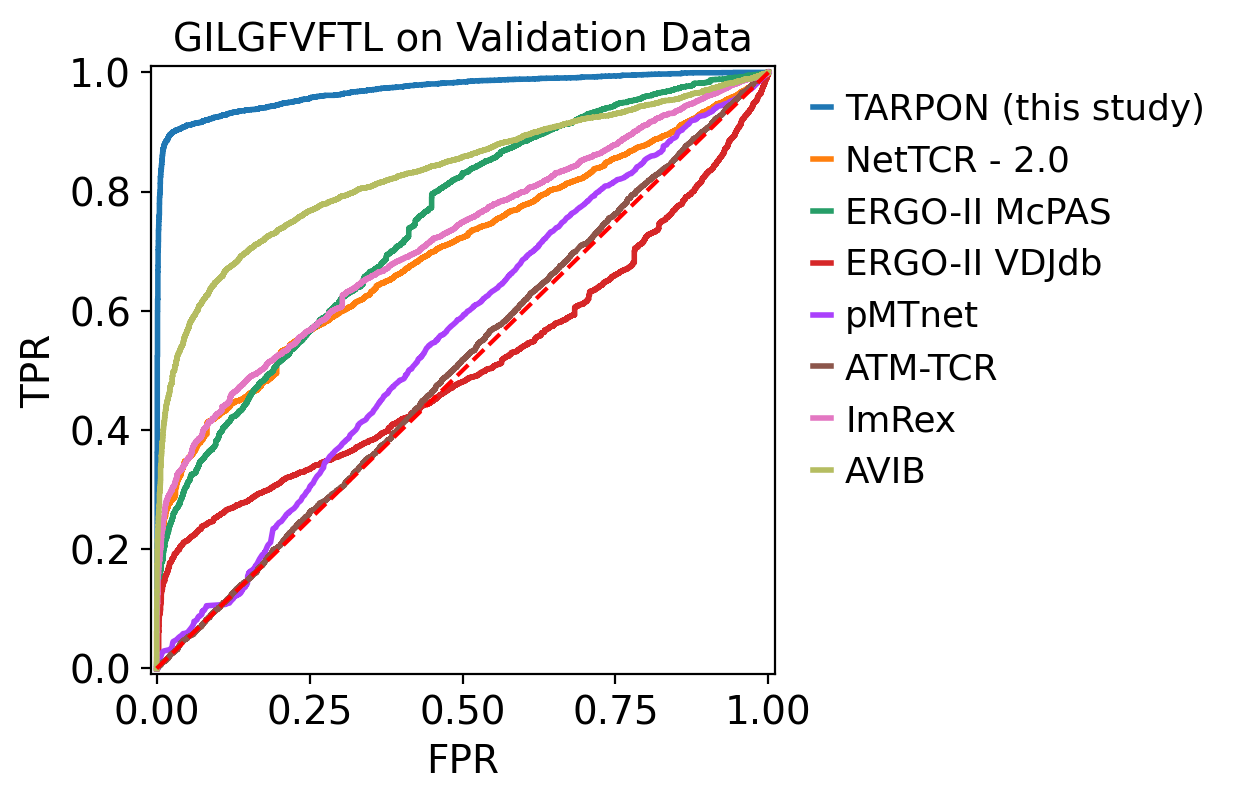

In [6]:
metrics_gil = evaluation('GILGFVFTL')

173/173 [==============================] - 0s 2ms/step
Model v5
AUC 0.9768817876983132
ACC 0.9305026311014335

pMTnet
AUC 0.49817016955581495
ACC 0.5115224097260025

ATM-TCR
AUC 0.5002117801385
ACC 0.5000907276356378

ImRex
AUC 0.4927471887767063
ACC 0.5037198330611504

Net-TCR-2.0
AUC 0.2553533751801053
ACC 0.3639992741789149

ERGO-II McPAS
AUC 0.8223767842608373
ACC 0.619851206677554

ERGO-II VDJdb
AUC 0.4442604026456713
ACC 0.4835782979495554

AVIB
AUC 0.6733531723558434
ACC 0.6205770277626566



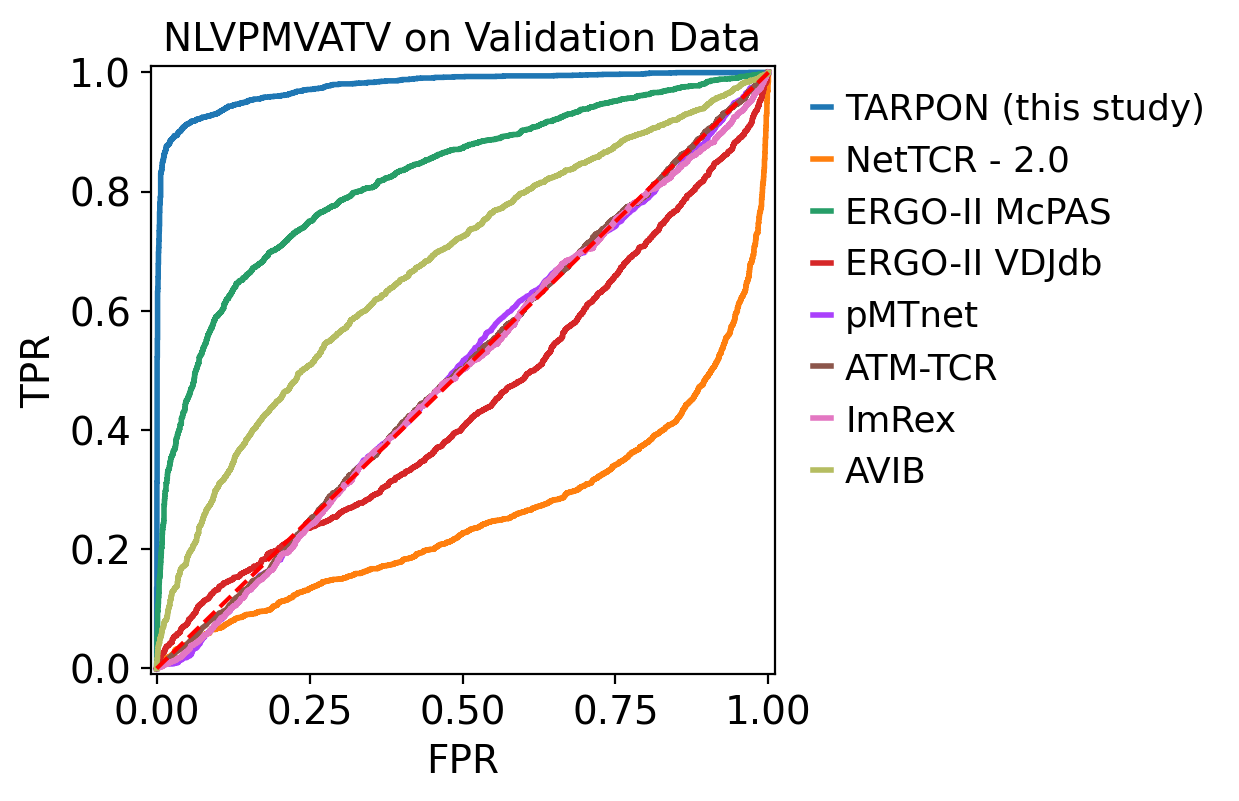

In [7]:
metrics_nlv = evaluation('NLVPMVATV')

348/348 [==============================] - 1s 2ms/step
Model v5
AUC 0.936599268647772
ACC 0.8706199460916442

pMTnet
AUC 0.37542539430051314
ACC 0.41626235399820305

ATM-TCR
AUC 0.4951308895232035
ACC 0.49739442946990114

ImRex
AUC 0.5808962056473577
ACC 0.5371069182389937

Net-TCR-2.0
AUC 0.5549944946930998
ACC 0.5398921832884097

ERGO-II McPAS
AUC 0.6432333160333543
ACC 0.5245283018867924

ERGO-II VDJdb
AUC 0.5977049010195902
ACC 0.4999101527403414

AVIB
AUC 0.6216478438309483
ACC 0.5959568733153638



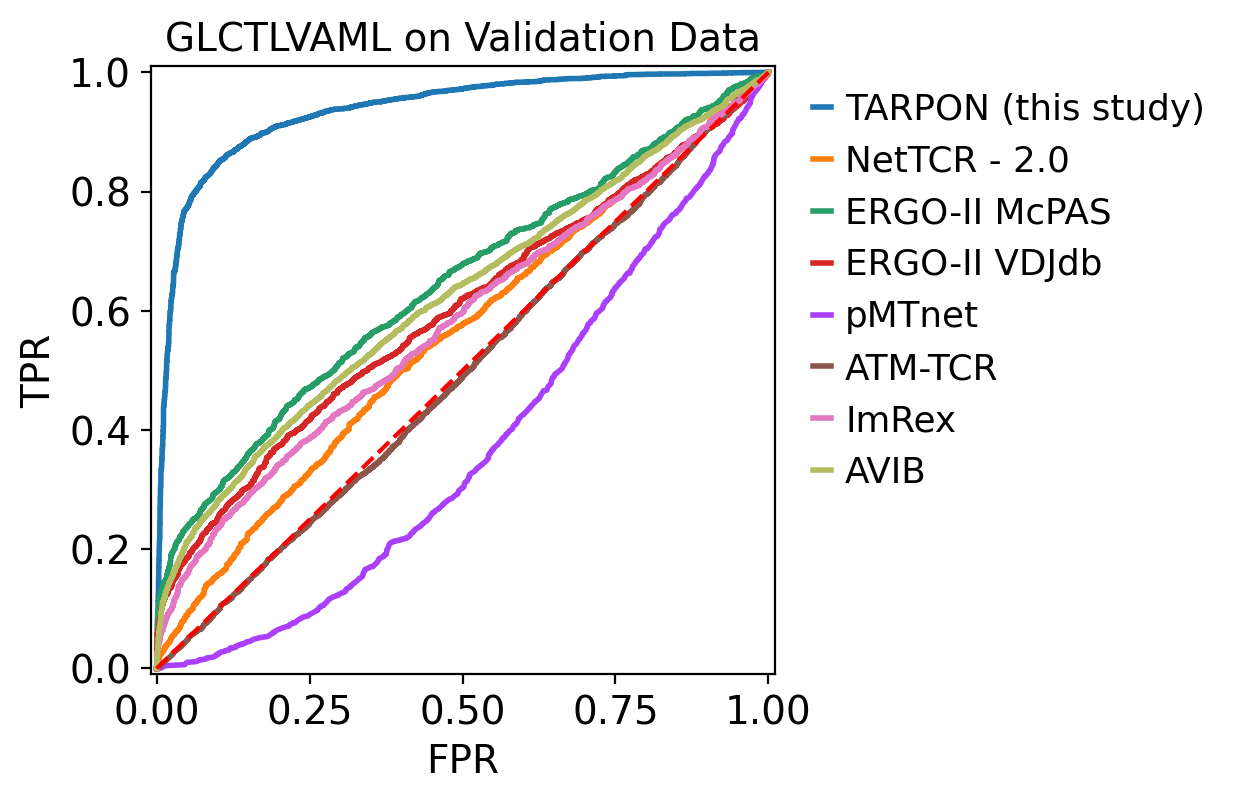

In [8]:
metrics_glc = evaluation('GLCTLVAML')

In [9]:
# add the antigen names
metrics_gil.index = 'GIL-' + metrics_gil.index
metrics_nlv.index = 'NLV-' + metrics_nlv.index
metrics_glc.index = 'GLC-' + metrics_glc.index
# combine the dataframe together
metrics = pd.concat([metrics_gil, metrics_nlv, metrics_glc], axis=0).T
# define acc columns and auc columns
cols_auc = metrics.columns[metrics.columns.str.endswith('-AUC')]
cols_acc = metrics.columns[metrics.columns.str.endswith('-ACC')]

In [10]:
order = metrics.mean(1).sort_values().index[::-1]

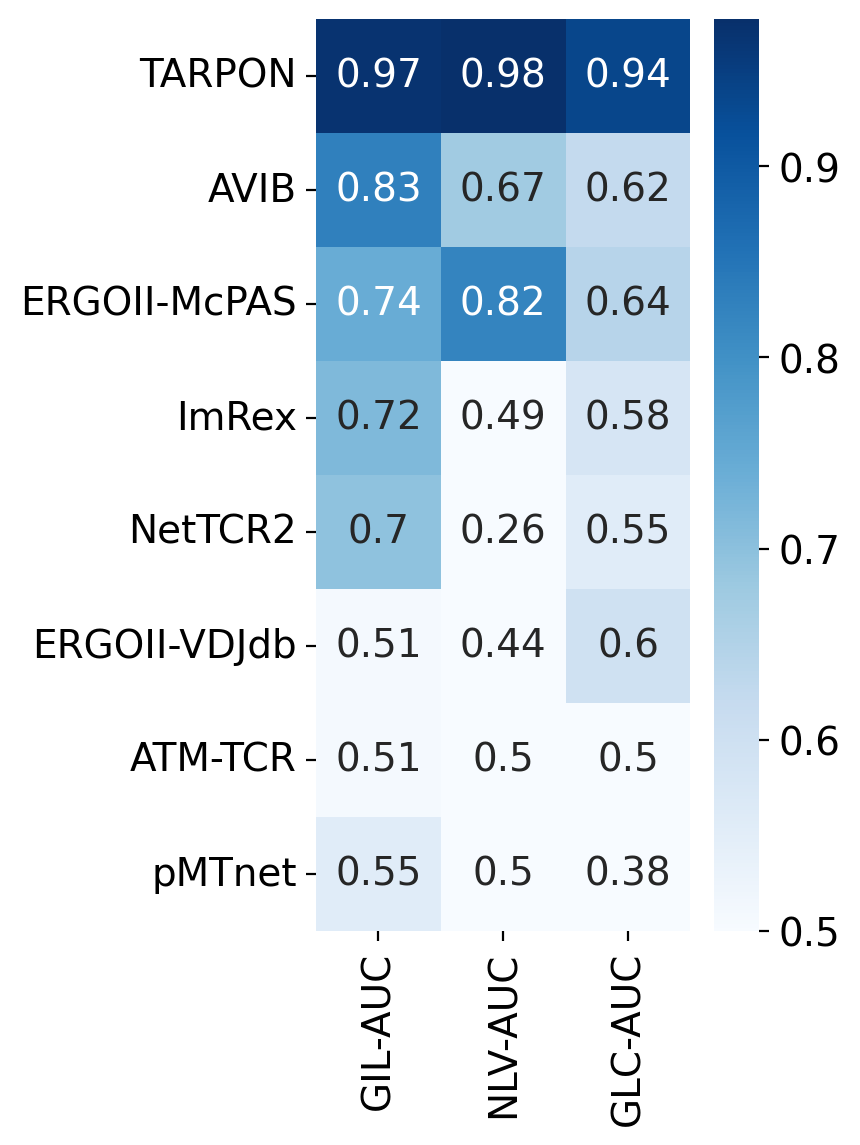

In [11]:
fig, ax = plt.subplots(figsize=[3, 6])
g = sns.heatmap(metrics.loc[order, cols_auc], annot=True, cmap='Blues', ax=ax, vmin=0.5)

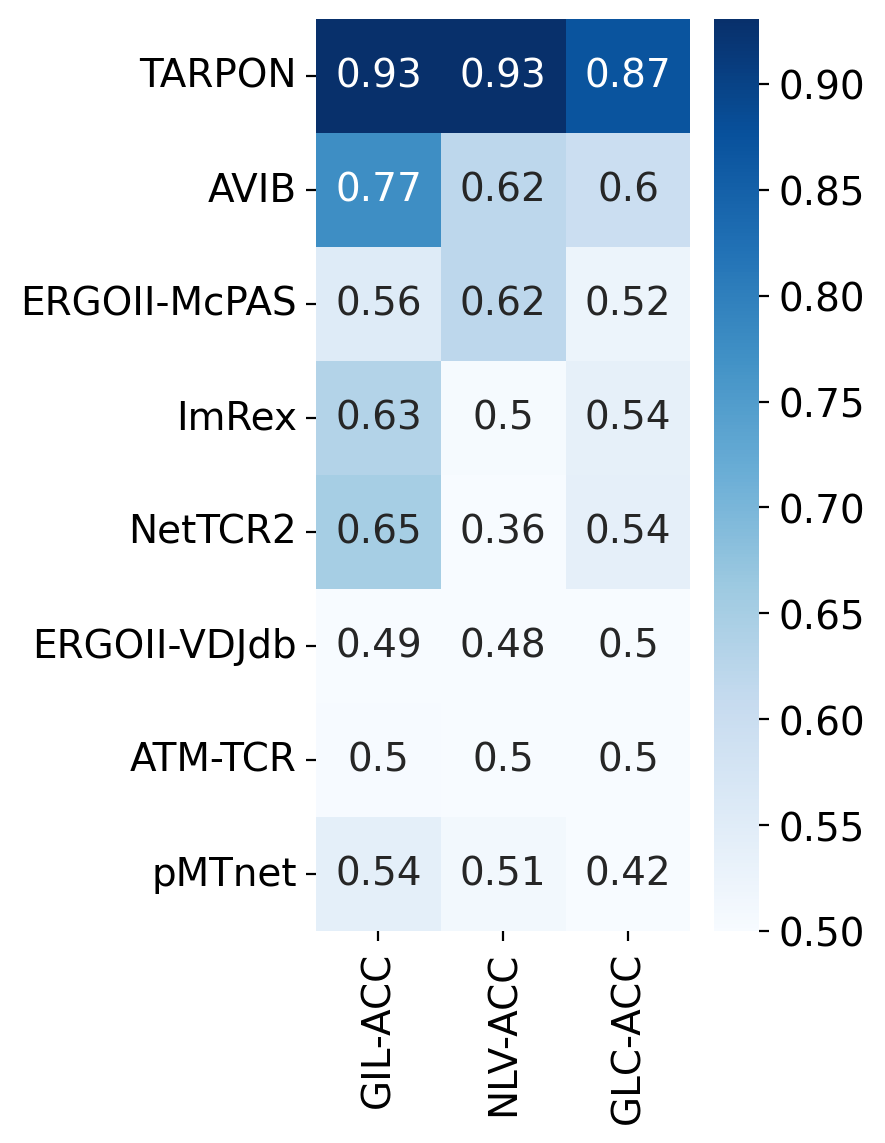

In [12]:
fig, ax = plt.subplots(figsize=[3, 6])
g = sns.heatmap(metrics.loc[order, cols_acc], annot=True, cmap='Blues', ax=ax, vmin=0.5)

In [13]:
import time

# read in model
model = keras.models.load_model('../outputs/model_v5/model_v5.r1.keras')

# prepare columns
cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

# prepare dataframe to subset out CDR3s from
df_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]

# set seed for random subsets
np.random.seed(0)

# retrieve timings
timings = pd.DataFrame(columns=['n_rows','total_time'])

# test for timings, this time for test not val dataset (approx the same)
n_rounds = 5
step_size = 4000
for round_num in range(n_rounds):
    # determine the size of values to grab
    size = step_size*(round_num+1)
    for _ in range(5):
        # grab the random idxs
        idxs = np.random.choice(X_val.index, size=size, replace=False)

        # testing predictions
        start_time = time.time()
        y_pred = model.predict([X_val[cols_cdr3].loc[idxs], X_val[cols_ag].loc[idxs]],
                               workers=1, use_multiprocessing=False)[:, 0]
        end_time = time.time()
        total_time = end_time - start_time

        # save data
        timings.loc[timings.shape[0]] = step_size*(round_num+1), total_time
    
    # gather the data
    X = df_val.loc[idxs].reset_index().iloc[:, 1:].copy()
    y = y_val.loc[idxs].reset_index().iloc[:, 1:].copy()
    
    # write for TARPON uncached
    fn = f'../outputs/model_comparison/val.timings.{size}.TARPON.csv'
    X.to_csv(fn)

    # write for ATM-TCR
    fn = f'../outputs/model_comparison/val.timings.{size}.ATM-TCR.csv'
    pd.concat([X, y], axis=1).to_csv(fn, header=False, index=False)

    # write for pMTnet
    tmp = X.copy()
    tmp['HLA'] = 'A*02:01'
    tmp.columns = ['CDR3','Antigen','HLA']
    fn = f'../outputs/model_comparison/val.timings.{size}.pMTnet.csv'
    tmp.to_csv(fn, index=False)

    # write for NetTCR2
    fn = f'../outputs/model_comparison/val.timings.{size}.NetTCR2.csv'
    X['CDR3'].to_csv(fn, header=False, index=False)

    # write for NetTCR2 (CLI version)
    fn = f'../outputs/model_comparison/val.timings.{size}.NetTCR2_CLI.csv'
    tmp = X.copy()
    tmp.columns = ['CDR3b','peptide']
    tmp['CDR3a'] = None
    tmp[['CDR3a','CDR3b','peptide']].to_csv(fn, index=False)

    # write for ImRex
    fn = f'../outputs/model_comparison/val.timings.{size}.ImRex.csv'
    tmp = X.copy()
    tmp.columns = ['cdr3','antigen.epitope']
    tmp.to_csv(fn, index=False, sep=';')

    # write for ERGO-II
    fn = f'../outputs/model_comparison/val.timings.{size}.ERGOII.csv'
    tmp = X.copy()
    X.columns = ['TRB','Peptide']
    X['MHC'] = 'HLA-A*02'
    X['T-Cell-Type'] = 'CD8'
    X = X.T.reindex(['TRA','TRB','TRAV','TRAJ','TRBV','TRBJ','T-Cell-Type','Peptide','MHC']).T
    X.to_csv(fn, index=False)

625/625 [==============================] - 1s 2ms/step


In [14]:
# create the model
timings = timings.iloc[:25, :2]
timings['model'] = 'TARPON'
# previous timings are maintained because, n-rows the same
# add in timings for ERGOII using CLI
# time python Predict.py vdjdb /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.timings.20000.ERGOII.csv > TMPTMP
for t in [6.6, 6.7, 6.6, 6.9, 6.9]:
    timings.loc[timings.shape[0]] = 4000, t, 'ERGOII-VDJdb'
for t in [9.3, 9.2, 9.9, 9.3, 9.6]:
    timings.loc[timings.shape[0]] = 8000, t, 'ERGOII-VDJdb'
for t in [12.6, 12.8, 12.6, 12.4, 12.4]:
    timings.loc[timings.shape[0]] = 12000, t, 'ERGOII-VDJdb'
for t in [14.9, 15.3, 14.4, 14.6, 14.7]:
    timings.loc[timings.shape[0]] = 16000, t, 'ERGOII-VDJdb'
for t in [16.8, 17.0, 17.3, 17.4, 17.2]:
    timings.loc[timings.shape[0]] = 20000, t, 'ERGOII-VDJdb'
# add in timings for ERGOII using CLI
# time python Predict.py mcpas /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.timings.20000.ERGOII.csv > TMPTMP
for t in [6.1, 5.9, 6.2, 5.7, 5.7]:
    timings.loc[timings.shape[0]] = 4000, t, 'ERGOII-McPAS'
for t in [8.6, 8.0, 8.6, 8.8, 8.2]:
    timings.loc[timings.shape[0]] = 8000, t, 'ERGOII-McPAS'
for t in [11.3, 11.3, 11.1, 11.8, 11.9]:
    timings.loc[timings.shape[0]] = 12000, t, 'ERGOII-McPAS'
for t in [13.5, 14.5, 14.2, 14.2, 14.1]:
    timings.loc[timings.shape[0]] = 16000, t, 'ERGOII-McPAS'
for t in [17.4, 17.4, 17, 17.3, 17.2]:
    timings.loc[timings.shape[0]] = 20000, t, 'ERGOII-McPAS'
# add in timings for NetTCR2 using web portal
for t in [26.7, 26.7, 35.2, 38.4, 45.6]:
    timings.loc[timings.shape[0]] = 4000, t, 'NetTCR2'
for t in [61.6, 54.7, 52.4, 60.0, 51.4]:
    timings.loc[timings.shape[0]] = 8000, t, 'NetTCR2'
for t in [77.4, 64.2, 101.4, 97.9, 91.4]:
    timings.loc[timings.shape[0]] = 12000, t, 'NetTCR2'
for t in [125.7, 61.4, 148.3, 58.6, 126.9]:
    timings.loc[timings.shape[0]] = 16000, t, 'NetTCR2'
for t in [171.1, 211.7, 115.2, 101.1, 148.7]:
    timings.loc[timings.shape[0]] = 20000, t, 'NetTCR2'
# # > code for running pMTnet
# python pMTnet.py \
# -input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.timings.4000.pMTnet.csv \
# -library /ssd1/dchen/GNN_PEPTIDE_TCR/external/pMTnet/library \
# -output /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/TMP \
# -output_log /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/TMP.log
for t in [1080, 1076, 1070, 1072, 1066]:
    timings.loc[timings.shape[0]] = 4000, t, 'pMTnet'
for t in [2208, 2193, 2169, 2163, 2212]:
    timings.loc[timings.shape[0]] = 8000, t, 'pMTnet'
for t in [3263, 3277, 3244, 3313, 3248]:
    timings.loc[timings.shape[0]] = 12000, t, 'pMTnet'
for t in [4513, 4538, 4468, 4516, 4517]:
    timings.loc[timings.shape[0]] = 16000, t, 'pMTnet'
for t in [5658, 5619, 5606, 5574, 5639]:
    timings.loc[timings.shape[0]] = 20000, t, 'pMTnet'
# # > code for running ATM-TCR
# python main.py --infile /ssd1/dchen/GNN_PEPTIDE_TCR/external/ATM-TCR/data/combined_dataset.csv \
# --indepfile /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.timings.4000.ATM-TCR.csv \
# --model_name original.ckpt --mode test --save_model False --cuda False
for t in [9.5, 9.0, 9.0, 9.2, 9.0]:
    timings.loc[timings.shape[0]] = 4000, t, 'ATM-TCR'
for t in [11.1, 11.4, 11.3, 11.5, 11.2]:
    timings.loc[timings.shape[0]] = 8000, t, 'ATM-TCR'
for t in [13.0, 12.8, 13.3, 13.9, 13.2]:
    timings.loc[timings.shape[0]] = 12000, t, 'ATM-TCR'
for t in [15.4, 15.2, 15.6, 15.1, 15.1]:
    timings.loc[timings.shape[0]] = 16000, t, 'ATM-TCR'
for t in [16.4, 16.7, 17.9, 17.9, 16.9]:
    timings.loc[timings.shape[0]] = 20000, t, 'ATM-TCR'
# # > code for ImRex
# python ./src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 \
# --input /ssd1/dchen/GNN_PEPTIDE_TCR/outputs/model_comparison/val.timings.4000.ImRex.csv \
# --output /ssd1/dchen/TMP/TMP.csv
for t in [7.2, 7.2, 7.3, 7.1, 7.3]:
    timings.loc[timings.shape[0]] = 4000, t, 'ImRex'
for t in [8.3, 8.4, 8.3, 8.4, 8.5]:
    timings.loc[timings.shape[0]] = 8000, t, 'ImRex'
for t in [9.7, 9.6, 9.5, 9.7, 9.9]:
    timings.loc[timings.shape[0]] = 12000, t, 'ImRex'
for t in [11.0, 11.2, 11.0, 10.9, 10.5]:
    timings.loc[timings.shape[0]] = 16000, t, 'ImRex'
for t in [12.2, 12.1, 11.7, 11.7, 12.2]:
    timings.loc[timings.shape[0]] = 20000, t, 'ImRex'
# # > code for AVIB
# ../notebooks/GNN_PEPTIDE_TCR/external/pred_for_vibtcr.ipynb
for t in [5344, 6808, 4009, 3140, 4455]:
    timings.loc[timings.shape[0]] = 4000, t, 'AVIB'
for t in [5345, 6808, 4010, 3141, 4455]:
    timings.loc[timings.shape[0]] = 8000, t, 'AVIB'
for t in [5345, 6809, 4010, 3141, 4456]:
    timings.loc[timings.shape[0]] = 12000, t, 'AVIB'
for t in [5345, 6809, 4010, 3141, 4456]:
    timings.loc[timings.shape[0]] = 16000, t, 'AVIB'
for t in [5346, 6809, 4011, 3142, 4456]:
    timings.loc[timings.shape[0]] = 20000, t, 'AVIB'

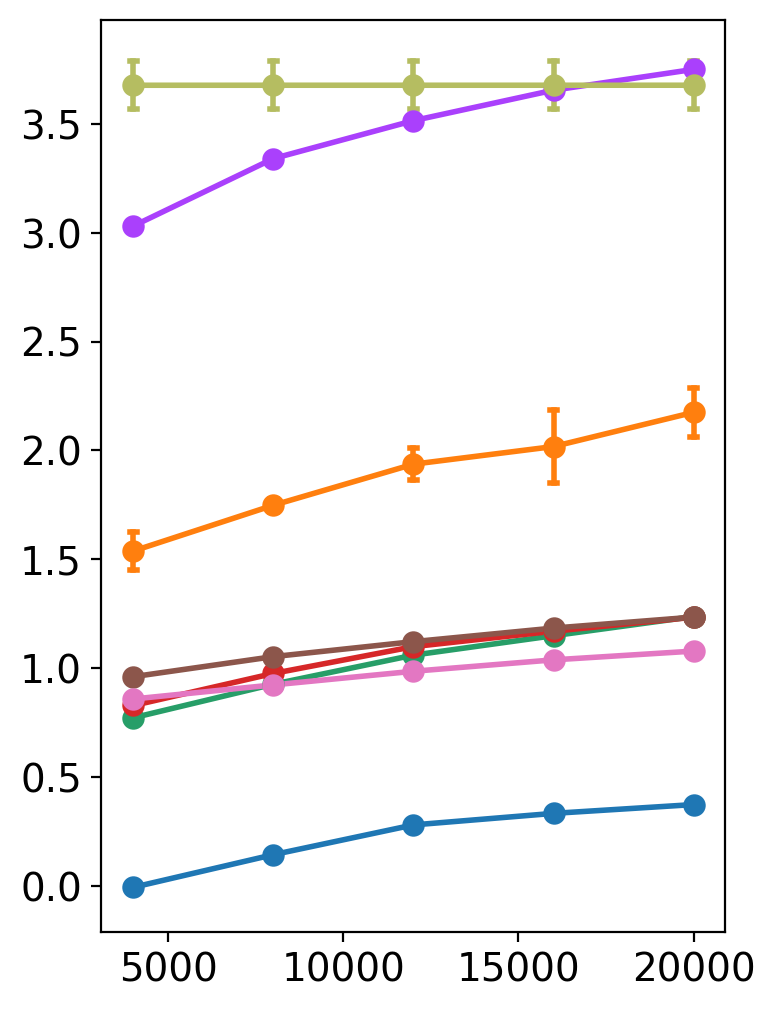

In [15]:
import matplotlib as mpl

# now do the actual plot
timings['log10_total_time'] = np.log10(timings['total_time'])

fig, ax = plt.subplots(figsize=[4, 6])
ax.grid(False)
order = ['TARPON','NetTCR2','ERGOII-McPAS','ERGOII-VDJdb','pMTnet','ATM-TCR','ImRex','AVIB']
palette = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2','#b5bd61']
for idx, color in zip(order, palette):
    mask = timings['model'] == idx
    vals_mean = timings.loc[mask][['n_rows','total_time']].groupby('n_rows').mean()
    vals_mean = np.log10(vals_mean.loc[:, 'total_time'])
    vals_ci95 = timings.loc[mask][['n_rows','log10_total_time']].groupby('n_rows').std()
    vals_ci95 = 1.96 * vals_ci95 / np.sqrt(5)
    ax.scatter(vals_mean.index, vals_mean, color=color, s=50, zorder=1)
    for idx in vals_mean.index:
        ax.plot([idx, idx], [vals_mean.loc[idx] - vals_ci95.loc[idx],
                             vals_mean.loc[idx] + vals_ci95.loc[idx]],
                color=color, zorder=-1, lw=2)
        ax.plot([idx-100, idx+100], [vals_mean.loc[idx] - vals_ci95.loc[idx],
                                     vals_mean.loc[idx] - vals_ci95.loc[idx]],
                color=color, zorder=-1, lw=2)
        ax.plot([idx-100, idx+100], [vals_mean.loc[idx] + vals_ci95.loc[idx],
                                     vals_mean.loc[idx] + vals_ci95.loc[idx]],
                color=color, zorder=-1, lw=2)
    ax.plot(vals_mean.index, vals_mean, color=color, lw=2, zorder=-1)
    

In [16]:
import scipy.stats as ss
mask = timings['model'] == 'TARPON'
pvalues = []
for idx in order[1:]:
    mask1 = timings['model'] == idx
    p = ss.mannwhitneyu(timings.loc[mask]['n_rows'] / timings.loc[mask]['total_time'],
                        timings.loc[mask1]['n_rows'] / timings.loc[mask1]['total_time'])[1]
    if p < 1e-4:
        print('****', end='|')
    print('{:.3e}'.format(p), idx)
    pvalues.append(p)
max(pvalues)

****|1.414e-09 NetTCR2
****|1.409e-09 ERGOII-McPAS
****|1.409e-09 ERGOII-VDJdb
****|1.416e-09 pMTnet
****|1.408e-09 ATM-TCR
****|1.405e-09 ImRex
****|1.416e-09 AVIB


1.4156562248495537e-09

In [17]:
# compare the prediction rates
mask = timings['model'] == 'TARPON'
rate = timings.loc[mask, 'n_rows'] / timings.loc[mask, 'total_time']
folds = []

for idx in order[1:]:
    mask = timings['model'] == idx
    for n_rows in timings.loc[mask, 'n_rows'].unique():
        maskt = timings['n_rows'] == n_rows
        rate1 = timings.loc[mask&maskt, 'n_rows'] / timings.loc[mask&maskt, 'total_time']
        fold = rate.mean() / rate1.mean()
        folds.append(fold)
        print(idx, fold)

NetTCR2 52.886079777204706
NetTCR2 44.58798183719468
NetTCR2 44.81315603262144
NetTCR2 35.76317684823914
NetTCR2 44.61728889047231
ERGOII-McPAS 9.461962483976539
ERGOII-McPAS 6.744526140473155
ERGOII-McPAS 6.118908474503368
ERGOII-McPAS 5.637559018879529
ERGOII-McPAS 5.523454205590278
ERGOII-VDJdb 10.780962207466734
ERGOII-VDJdb 7.563412359080124
ERGOII-VDJdb 6.698534446215692
ERGOII-VDJdb 5.910214536033723
ERGOII-VDJdb 5.484596662563594
pMTnet 1716.6540839619913
pMTnet 1751.2680272090358
pMTnet 1743.5782281762567
pMTnet 1804.3325111610657
pMTnet 1798.3159182011852
ATM-TCR 14.619200659016157
ATM-TCR 9.039683982926173
ATM-TCR 7.0567258391129295
ATM-TCR 6.111766987286943
ATM-TCR 5.484640197869715
ImRex 11.552160287274711
ImRex 6.704282863612605
ImRex 5.162329887821392
ImRex 4.366532265628773
ImRex 3.832625268139248
AVIB 7103.208033348032
AVIB 3552.2303475429035
AVIB 2368.3048636659305
AVIB 1776.2286477494483
AVIB 1421.2334338015187


In [18]:
# print out timings for 20k rows
print('TARPON', round(timings.loc[(timings['n_rows'] == 20000)&(timings['model'] == 'TARPON'), 'total_time'].mean()), 'sec')
print('pMTnet', round(timings.loc[(timings['n_rows'] == 20000)&(timings['model'] == 'pMTnet'), 'total_time'].mean() / 60 / 60), 'hr')

TARPON 2 sec
pMTnet 2 hr


In [19]:
# look at the speed increase
print(min(folds), np.mean(folds), max(folds))

3.832625268139248 725.767881627902 7103.208033348032


In [21]:
# save the values
timings.to_csv('timings.csv')